# Прогнозирование температуры звезды

Целью проекта является построение нейросети, определяющей температуру на поверхности звёзд. Заказчиком проекта является обсерватория «Небо на ладони», представившая характеристики уже изученных 240 звёзд, включающие следующие параметры: 

Luminosity(L/Lo) - относительная светимость (светимость звезды относительно Солнца);

Radius(R/Ro) - относительный радиус (радиус звезды относительно радиуса Солнца);

Absolute magnitude(Mv) - абсолютная звёздная величина (физическая величина, характеризующая блеск звезды);

звёздный цвет  — цвет звезды, который определяют на основе спектрального анализа;

Star color - тип звезды;

Temperature (K)	- абсолютная температура (температура на поверхности звезды в Кельвинах).

## Загрузка данных

Перед началом построения модели машинного обучения  мы проведем изучение данных, их предварительную обработку (если потребуется), в соответствии с условием проекта проведем графический анализ.

Импортируем небходимые библиотеки и загружаем данные.

In [46]:
import pandas as pd

import numpy as np
from numpy.random import RandomState
import random

from math import ceil, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [47]:
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
torch.use_deterministic_algorithms(True)

In [48]:
try:

    data = pd.read_csv("C:\\Users\\User\\Downloads\\6 class csv.csv")
    data = data.drop('Spectral Class', axis=1)
    
except:

    data = pd.read_csv('/datasets/6_class.csv',index_col=0)    


In [49]:
data.head(3)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [51]:
data.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [52]:
data.duplicated().sum()

0

Исходный датасет представлен 240 объектами каждый из которых имеет 5 признаков и целевой признак "Temperature (K)". Целевой признак и 3 признака количественные типа "int64 " и "float64", 2 признака "Star color" и "Star type" категориальные. Пропуски в данных и полные дубликаты отсутствуют.

## Предобработка и анализ данных

Приведем наименования столбцов к общепринятому формату.

In [53]:
data = data.rename(columns = {'Temperature (K)': 'temperature', 'Luminosity(L/Lo)' : 'luminosity', 'Radius(R/Ro)':'radius',
       'Absolute magnitude(Mv)':'absolute_magnitude', 'Star type':'star_type', 'Star color':'star_color'})

display(data)
data.shape

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


(240, 6)

### Исследование количественных признаков

Количественные данные представлены в столбцах "temperature" (целевой признак), "luminosity", "radius" и "absolute_magnitude".  Выведем их основные описательные статистики и составим гистограммы.

In [54]:
a = data[['temperature', 'luminosity', 'radius', 'absolute_magnitude']].describe()
a

,temperature,luminosity,radius,absolute_magnitude
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


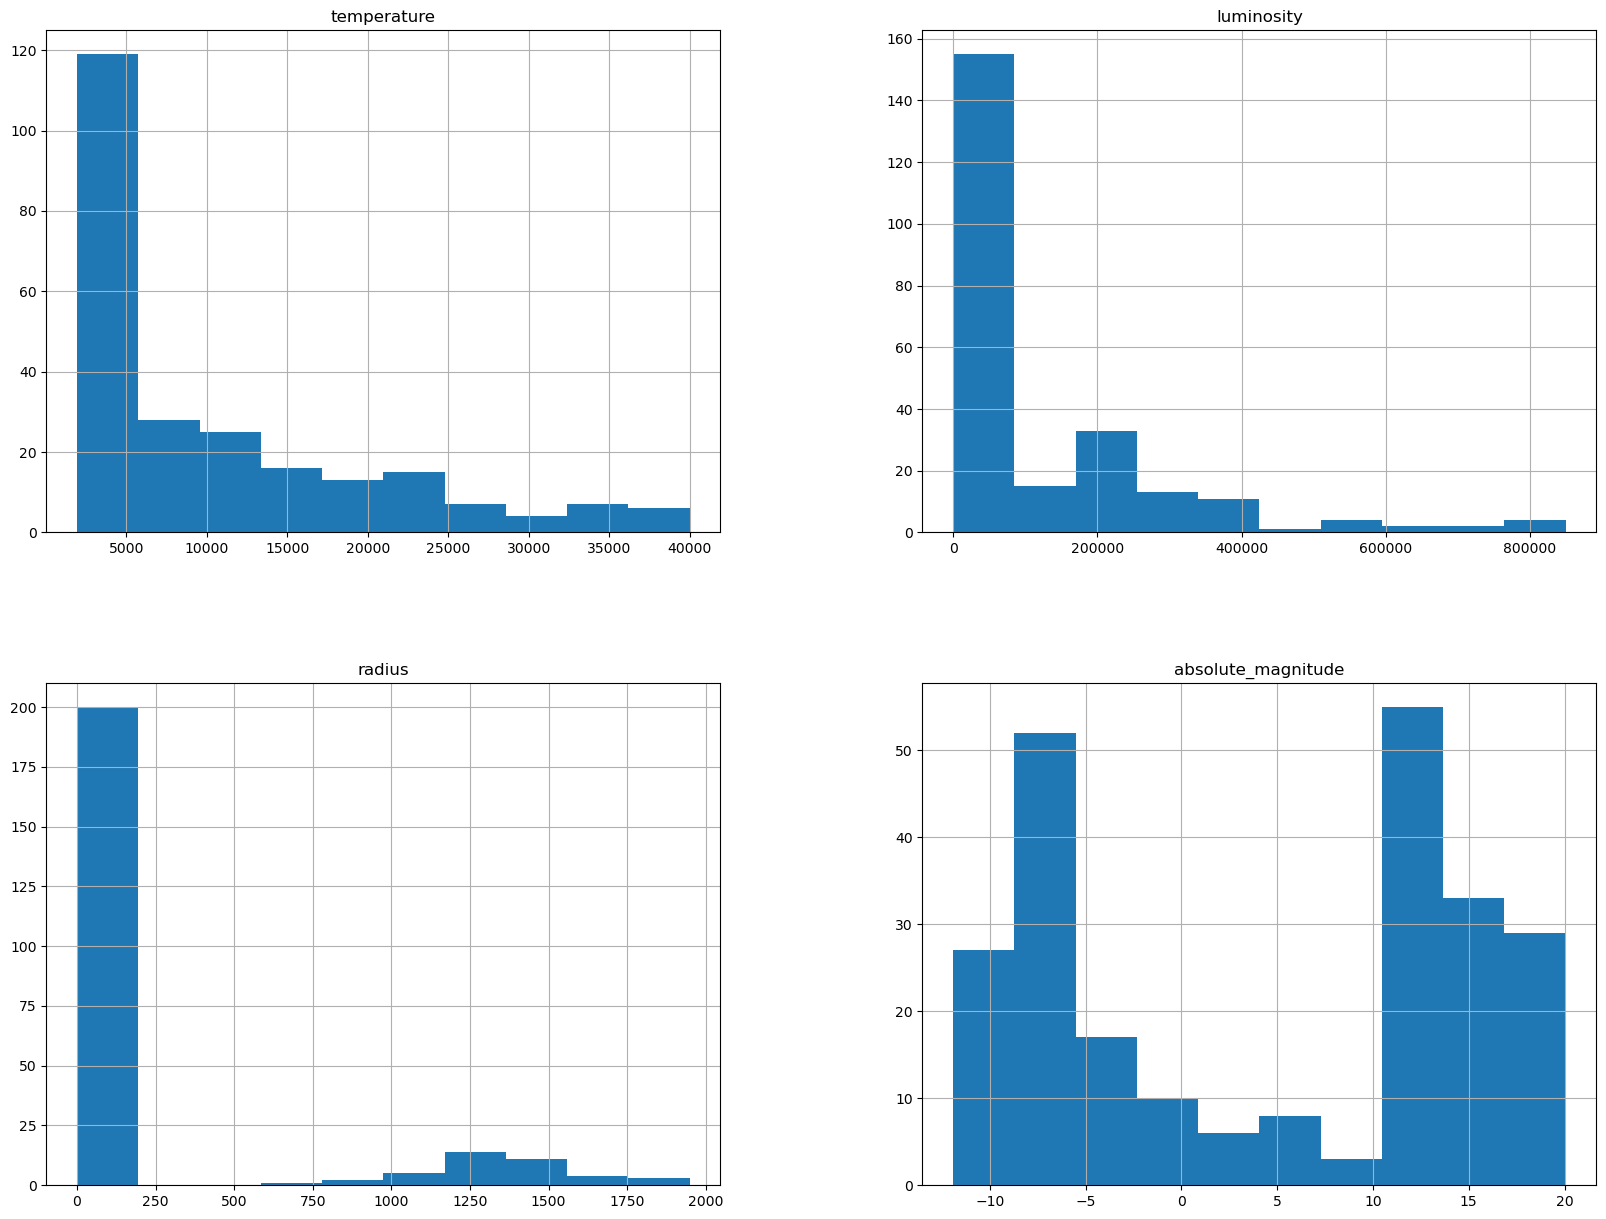

In [55]:
ax = data[['temperature', 'luminosity', 'radius', 'absolute_magnitude']].hist(figsize=(20, 15))

#### Температура
Значения целевого признака 'temperature' все положительные, варируются в пределах от 1939 до 40000 градусов по Кельвину. Почти половина звезд имеет температуру ок 6000 градусов. Звезды, имеющие температуру более 15000 градусов находятся за пределами третьей квартили общего их количества. Звезды с температурой более 25000 градусов можно считать выбросами в датасете, которые мы не станем удалять ввиду общего малого количества объектов для построения модели машинного обучения.

#### Относительная светимость
Значения относительной светимости звезд также как и температуры можно считать экспоненциально распределенными.

#### Относительный радиус
Значения относительного радиуса звезд распределены очень неравномерно. В них имеются так называемые провалы между значениями, характерными для абсолютного большинства звезд (ок. 200) и значениями, находящимися в четвертой квартили.

#### Абсолютная звёздная величина

Признак абсолютной звездной величины представлен как отрицательными так и положительными значениями что абсолютно нормально для этого показателя. Распределение их таково, что отмечаются "всплески" данных в отрицательных и положительных значениях.

Посмотрим на корреляцию количественных признаков

In [56]:
a.corr()

,temperature,luminosity,radius,absolute_magnitude
temperature,1.000000,0.984271,0.909212,-0.240143
luminosity,0.984271,1.000000,0.961277,-0.144352
radius,0.909212,0.961277,1.000000,-0.000841
absolute_magnitude,-0.240143,-0.144352,-0.000841,1.000000


Между температурой звезды с одной стороны и ее относительной светимостью и относительным радиусом с другой имеется высокая положительная корреляция. Между температурой и абсолютной звездной величиной - незначительная отрицательная. 

Незначительная отрицательная корреляция наблюдается между абсолютной звездной величиной и радиусом и светимостью.

Прямая пропорциональная зависимость отмечается между радиусом и светимостью.


### Исследование категориальных признаков

#### Тип звезды

In [57]:
data['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

Признак 'star_type' категориальный, переведен в цельночисленные данные, содержит 6 значений, представленных в равном количестве.

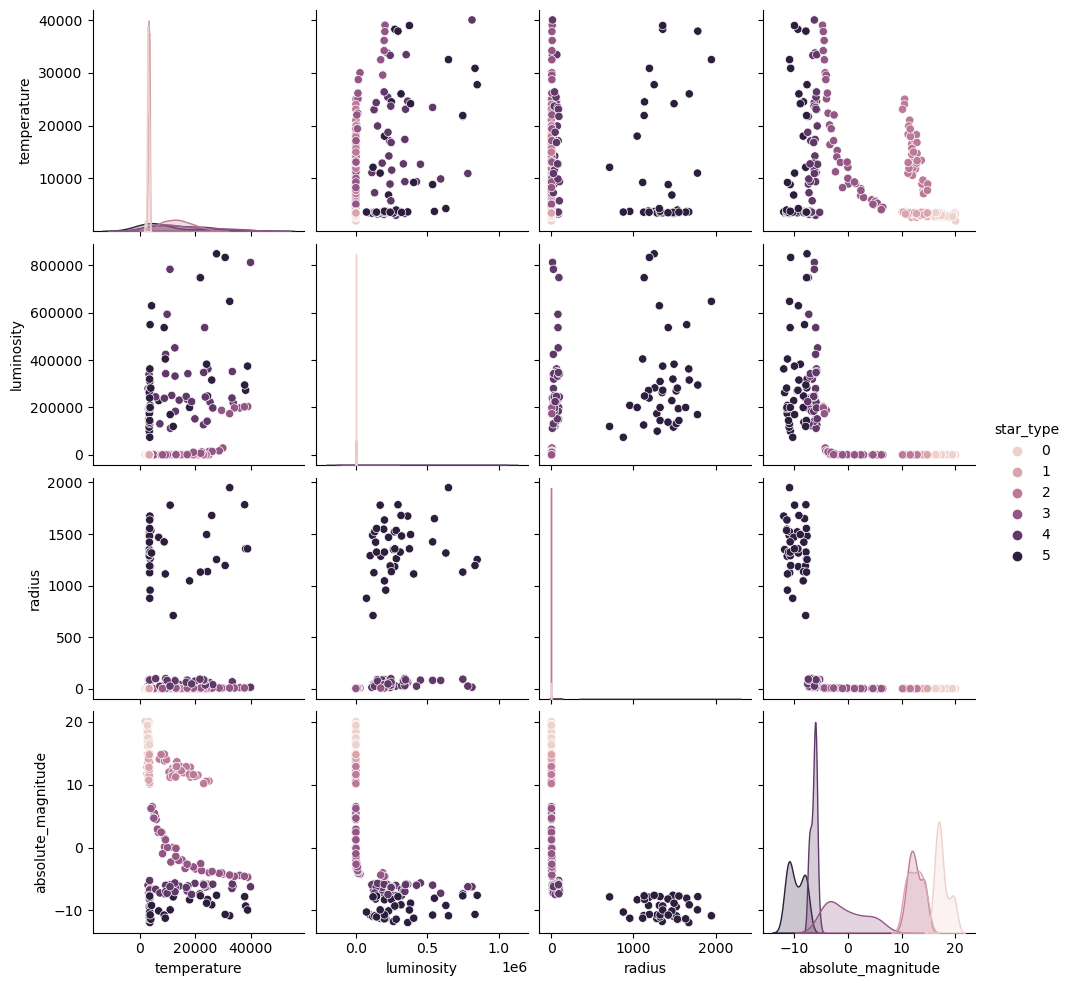

In [58]:
ax = sns.pairplot(data, hue='star_type')

На графике можно проследить распределение типов звезд по совокупностям признаков. Но нас больше интересует целевой признак (температура), его и рассмотрим. Звезды, явлющиеся гипергигантами (5 тип) и звезды главной последовательности (тип 3) имеют максимальный диапазон температурного режима- от 0 почти до 40000 градусов по Кельвину. Наиболее холодными являются Коричневые (тип 0) и Красные (тип 1) карлики. Их температура находится в пределах 2000-5000 К. Белые карлики (тип 2) и сверхгиганты (тип 4), в основном, тяготеют к среднему температурному диапазону - 8000-25000 К.  

#### Звездный цвет

In [59]:
print('star_color', data['star_color'].sort_values().unique())
print('')
print(data['star_color'].value_counts())

star_color ['Blue' 'Blue ' 'Blue White' 'Blue white' 'Blue white ' 'Blue-White'
 'Blue-white' 'Orange' 'Orange-Red' 'Pale yellow orange' 'Red' 'White'
 'White-Yellow' 'Whitish' 'Yellowish' 'Yellowish White' 'white'
 'yellow-white' 'yellowish']

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: star_color, dtype: int64


Данные признака  'star_color' содержат категориальные значеня в которых много дубликатов следующего вида: написание одних и тех же названий разным шрифтом, пробелы в наименованиях, наличие-отсутствие дефисов, изменение порядка слов в двойных наименованиях, наличие синонимов для одного и того же наименования. Для устранения дубликатов напишем функцию для замены значений, которую применим ко всем цветам.

In [60]:
def replace_star_color(star_color,correct_color):
    data['star_color'] = data['star_color'].replace(star_color,correct_color)   
replace_star_color(['Blue White','Blue white','Blue white ', 'Blue-White'],'Blue-white')
replace_star_color(['white', 'Whitish'],'White')
replace_star_color('yellowish','Yellowish')
replace_star_color('Blue ', 'Blue')
replace_star_color(['yellow-white','Yellowish White'],'White-Yellow')
replace_star_color(['Orange', 'Pale yellow orange','Orange-Red'  ],'Othes')

print('star_color', data['star_color'].sort_values().unique())

star_color ['Blue' 'Blue-white' 'Othes' 'Red' 'White' 'White-Yellow' 'Yellowish']


Визуализируем полученные данные

,star_color,star_count
0,Blue,56
1,Blue-white,41
2,Othes,4
3,Red,112
4,White,12
5,White-Yellow,12
6,Yellowish,3


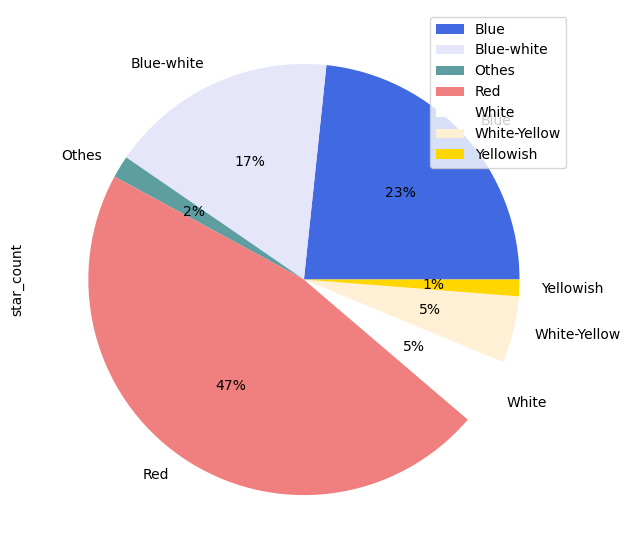

In [61]:
d = pd.DataFrame({'star_color': ['Blue', 'Blue-white', 'Othes', 'Red', 'White', 'White-Yellow', 'Yellowish'],
                          'star_count': [56, 41, 4, 112, 12, 12,3]})
colors = ['royalblue', 'lavender','cadetblue','lightcoral', 'White','papayawhip', 'gold']#cornflower
  
d.groupby(['star_color']).sum().plot(kind='pie', y='star_count', autopct='%1.0f%%', colors=colors, figsize=(7, 7))
d

Почти половина всех звезд, о которых имеются данные в датасете имеют красный цвет (112), на втором месте по количеству - звезды, излучающие синий цвет (56), на третьем (41) - звезды сине-белого цвета. Звезды, имеющие значеня 'Orange', 'Pale yellow orange','Orange-Red' в исходном датасете были представлены в единичном количестве и мы их объединили в одну цветовую категорию - 'Othes'.

<b> Вывод:</b> Исходный датасет представлен 240 объектами каждый из которых имеет 5 признаков и целевой признак "Temperature (K)".     
   
Четыре признака, включая целевой, представлены количественными значениями, два - категориальными, один из которых переведен в цельночисленный тип. В двух количественных  признаках ('temperature' и 'luminosity') данные можно считать нормально распределенными. гистограммы признаков 'radius' и 'absolute_magnitude' показывают, что в значениях есть "провалы", что говорит об их неравномерном распределении. Во всех данных, кроме 'star_type', имеются выбросы, от которых мы не будем избавляться ввиду малого количества  объектов для построения модели машинного обучения.    
    
Предварительная обработка данных состояла в приведении наименований столбцов датасета к общепринятому формату (змеиному регистру), устранению дуюликатов в признаке 'star_color', объединении единичных значений этого признака в категорию 'Othes'. 
    
Исследование взаимозависимости  признаков выявило между температурой звезды с одной стороны и ее относительной светимостью и относительным радиусом с другой высокую положительную корреляции. Между температурой и абсолютной звездной величиной - незначительную отрицательную. Также прослеживается взаимосвязь между типом звезды и температурой на ее поверхности.    

## Подготовка данных к построению модели

В исходном датасете выделяем признаки "features" и целевой признак "target"

In [62]:
features = data.drop('temperature', axis=1)
target = data['temperature']

display(features.head())
print(target.head())

,luminosity,radius,absolute_magnitude,star_type,star_color
0,0.002400,0.1700,16.12,0,Red
1,0.000500,0.1542,16.60,0,Red
2,0.000300,0.1020,18.70,0,Red
3,0.000200,0.1600,16.65,0,Red
4,0.000138,0.1030,20.06,0,Red


0    3068
1    3042
2    2600
3    2800
4    1939
Name: temperature, dtype: int64


Из набора признаков и целевого ризнака делаем выборки для обучения и тестирования в соотношении 3:1. Чтоб избежать утечки данных признаков дальнейшую обработку данных будем производить отдельно по каждой выборке.

In [63]:
STATE = RandomState(12345)

test_features, train_features,  test_target, train_target  = train_test_split(features, target, 
                                                    train_size=0.25,  
                                                    random_state=STATE,
                                                    stratify=features['star_color'],                          
                                                    shuffle=True)
print('Размеры выборок:')
print('train_features',train_features.shape)
print('test_features', test_features.shape)
print('train_target', train_target.shape)
print('test_target', test_target.shape)

Размеры выборок:
train_features (180, 5)
test_features (60, 5)
train_target (180,)
test_target (60,)


Проверяем равномерность распределения значений категориальных признаков в учебной и тестовых выборках. 

In [64]:
print(len(train_features['star_color'].sort_values().unique()))
print(len(test_features['star_color'].sort_values().unique()))
print('')
print(len(train_features['star_type'].sort_values().unique()))
print(len(test_features['star_type'].sort_values().unique()))

7
7

6
6


Кодируем признаки техникой OHE

In [67]:
categorical = ['star_color', 'star_type']#
numerics = ['luminosity', 'radius', 'absolute_magnitude']

onehot_encoder = OneHotEncoder(sparse=False, drop='first')

result_train = onehot_encoder.fit_transform(train_features[categorical])
result_train = pd.DataFrame(result_train, columns=onehot_encoder.get_feature_names(categorical), index=train_features.index)

features_ohe_train = result_train.join(train_features[numerics])
display(features_ohe_train.head(3))
features_ohe_train.info()

,star_color_Blue-white,star_color_Othes,star_color_Red,star_color_White,star_color_White-Yellow,star_color_Yellowish,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,luminosity,radius,absolute_magnitude
235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,374830.000000,1356.0000,-9.93
129,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000437,0.0856,18.09
98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,689.000000,7.0100,0.02


<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 235 to 4
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   star_color_Blue-white    180 non-null    float64
 1   star_color_Othes         180 non-null    float64
 2   star_color_Red           180 non-null    float64
 3   star_color_White         180 non-null    float64
 4   star_color_White-Yellow  180 non-null    float64
 5   star_color_Yellowish     180 non-null    float64
 6   star_type_1              180 non-null    float64
 7   star_type_2              180 non-null    float64
 8   star_type_3              180 non-null    float64
 9   star_type_4              180 non-null    float64
 10  star_type_5              180 non-null    float64
 11  luminosity               180 non-null    float64
 12  radius                   180 non-null    float64
 13  absolute_magnitude       180 non-null    float64
dtypes: float64(14)
memory usag

In [68]:
result_test = onehot_encoder.transform(test_features[categorical])
result_test = pd.DataFrame(result_test, columns=onehot_encoder.get_feature_names(categorical), index=test_features.index)

features_ohe_test = result_test.join(test_features[numerics])
display(features_ohe_test.head(3))
features_ohe_test.info()

,star_color_Blue-white,star_color_Othes,star_color_Red,star_color_White,star_color_White-Yellow,star_color_Yellowish,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,luminosity,radius,absolute_magnitude
56,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,363000.000000,1673.00000,-11.92
140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000590,0.00981,13.67
183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000452,0.09870,17.34


<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 56 to 114
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   star_color_Blue-white    60 non-null     float64
 1   star_color_Othes         60 non-null     float64
 2   star_color_Red           60 non-null     float64
 3   star_color_White         60 non-null     float64
 4   star_color_White-Yellow  60 non-null     float64
 5   star_color_Yellowish     60 non-null     float64
 6   star_type_1              60 non-null     float64
 7   star_type_2              60 non-null     float64
 8   star_type_3              60 non-null     float64
 9   star_type_4              60 non-null     float64
 10  star_type_5              60 non-null     float64
 11  luminosity               60 non-null     float64
 12  radius                   60 non-null     float64
 13  absolute_magnitude       60 non-null     float64
dtypes: float64(14)
memory usag

Масштабируем признаки на учебной и тестовой выборках

In [69]:
scaler = StandardScaler()

scaler.fit(features_ohe_train[numerics]) 
features_ohe_train[numerics] = scaler.transform(features_ohe_train[numerics])
display(features_ohe_train.head(3))
features_ohe_train.info()

features_ohe_test[numerics] = scaler.transform(features_ohe_test[numerics])
display(features_ohe_test.head(3))
features_ohe_test.info()

,star_color_Blue-white,star_color_Othes,star_color_Red,star_color_White,star_color_White-Yellow,star_color_Yellowish,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,luminosity,radius,absolute_magnitude
235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.377087,2.153267,-1.365881
129,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.580933,-0.458638,1.289532
98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.577334,-0.445300,-0.422935


<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 235 to 4
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   star_color_Blue-white    180 non-null    float64
 1   star_color_Othes         180 non-null    float64
 2   star_color_Red           180 non-null    float64
 3   star_color_White         180 non-null    float64
 4   star_color_White-Yellow  180 non-null    float64
 5   star_color_Yellowish     180 non-null    float64
 6   star_type_1              180 non-null    float64
 7   star_type_2              180 non-null    float64
 8   star_type_3              180 non-null    float64
 9   star_type_4              180 non-null    float64
 10  star_type_5              180 non-null    float64
 11  luminosity               180 non-null    float64
 12  radius                   180 non-null    float64
 13  absolute_magnitude       180 non-null    float64
dtypes: float64(14)
memory usag

,star_color_Blue-white,star_color_Othes,star_color_Red,star_color_White,star_color_White-Yellow,star_color_Yellowish,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,luminosity,radius,absolute_magnitude
56,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.315290,2.763906,-1.554471
140,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.580933,-0.458784,0.870655
183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.580933,-0.458613,1.218455


<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 56 to 114
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   star_color_Blue-white    60 non-null     float64
 1   star_color_Othes         60 non-null     float64
 2   star_color_Red           60 non-null     float64
 3   star_color_White         60 non-null     float64
 4   star_color_White-Yellow  60 non-null     float64
 5   star_color_Yellowish     60 non-null     float64
 6   star_type_1              60 non-null     float64
 7   star_type_2              60 non-null     float64
 8   star_type_3              60 non-null     float64
 9   star_type_4              60 non-null     float64
 10  star_type_5              60 non-null     float64
 11  luminosity               60 non-null     float64
 12  radius                   60 non-null     float64
 13  absolute_magnitude       60 non-null     float64
dtypes: float64(14)
memory usag

<b> Вывод:</b> Мы разделили данные на учебную и тестовую выборки в соотношении 3:1, после чего обрабатывали данные раздельно по выборкам. К категориальным признакам "star_color" и  "star_type" применена техника OHE.
    
Количественные признаки 'luminosity', 'radius', 'absolute_magnitude' масштабированы. 

## Построение базовой нейронной сети

Построение модели нейронной сети осуществим с использованием библиотеки Torch, которую мы импортировали. Для этого переведем наборы признаков и целевого признака учебной и тестовой выборок в тензоры.

In [72]:
X_train = torch.FloatTensor(features_ohe_train.values)
X_test = torch.FloatTensor(features_ohe_test.values)
y_train = torch.FloatTensor(train_target.values)
y_test = torch.FloatTensor(test_target.values)

print(X_train.size())
print(X_test.size())
print(y_train.size())
print(y_test.size())

torch.Size([180, 14])
torch.Size([60, 14])
torch.Size([180])
torch.Size([60])


Создадим архитектуру полносвязной нейронной сети c тремя скрытыми слоями. После первого и третьего слоев применим функцию активации ReLU, после второго и выходного - ее модимикации ELU и LeakyReLU соответственно.

Количество нейронов входного и выходного слоев определим по ширине тензора обучающей выборки (X_train.shape[1]) и количеству целевых признаков(1). В первом скрытом слое определим количество нейронов 100, втором - 50, третьем - 10. Количество эпох обучения - 2000.

Определим метод forward, принимающий на вход тензор и возвращающий его на выходе после прохождения через нейронную сеть и объявим объект класса - net. 

In [73]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 100
n_hidden_neurons_2 = 50
n_hidden_neurons_3 = 10
n_out_neurons = 1 

In [74]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                 n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ELU() 
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3) 
        self.act3 = nn.ReLU() 

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.act4 = nn.LeakyReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        x = self.act4(x)
        
        return x

net = Net(n_in_neurons,
          n_hidden_neurons_1,
          n_hidden_neurons_2,
          n_hidden_neurons_3,
          n_out_neurons
         )
print(net)


Net(
  (fc1): Linear(in_features=14, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (act2): ELU(alpha=1.0)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=10, out_features=1, bias=True)
  (act4): LeakyReLU(negative_slope=0.01)
)


Нейронная сеть "net" заданной архитектуры инициализирована.

Теперь перезапишем ее через объект класса-контейнера Sequential и посчитаем метрику качества предсказаний RMSE.

Для нахождения лучших значений параметров на тренировочных данных в решении задачи регрессии выберем функцию потерь MAE (в модуле torch.nn это L1Loss)

Зададим алгоритм оптимизации Adam.

Алгоритм обучения будет состоять из следующих шагов:

перед каждым шагом обучения методом zero_grad() обнулим накопленный градиент,

вычислим текущие предсказания модели,

подсчитаем значение функции потерь и с помощью метода backward() вычислим значение градиента функции потерь,

выполним шаг работы оптимизатора (обновление весов в сети),

выведем динамику метрики качества переведя модель в режим предсказаний техникой eval().

In [75]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_3, n_out_neurons), 
    nn.LeakyReLU()
)

num_epochs = 2000

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.L1Loss()     
   
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten() 
            
    loss_value = loss(preds, y_train)
    loss_value.backward()
            
    optimizer.step()
    
    with torch.no_grad():
        net.eval()
        test_preds = net.forward(X_test)
        
        rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
print('RMSE: ',rmse_metric) 
h = rmse_metric
h

RMSE:  6449


6449

Теперь попробуем построить нейросеть с одним скрытым слоем 200 нейронов. Количество эпох обучения установим 800.

In [76]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 200
n_out_neurons = 1 


net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_out_neurons), 
    nn.LeakyReLU()
)

num_epochs = 800

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.L1Loss()     
   
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten() 
            
    loss_value = loss(preds, y_train)
    loss_value.backward()
            
    optimizer.step()
    
    with torch.no_grad():
        net.eval()
        test_preds = net.forward(X_test)
        
        rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
print('RMSE: ',rmse_metric) 
v = rmse_metric
v

RMSE:  13099


13099

В модели с одним скрытым слоем количество эпох увеличено со 100 до 800, однако это метрику качества не улучшило.

Построим нейронную сеть с двумя скрытыми слоями и количеством нейронов 10, 500, 800, 1 с функцией активации ReLU и ее модимикациями ELU и LeakyReLU  и подберем количество эпох обучения в диапазоне от 1 до 10001 при которых метрика качества предсказаний  RMSE будет наименьшей. Выведем динамику метрики качества для каждой 100 эпохи.

Для контроля количества эпох применим EarlyStopping.

In [77]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 500
n_hidden_neurons_2 = 800
n_out_neurons = 1 

EPOCH:  100   RMSE:  12178
EPOCH:  200   RMSE:  8758
EPOCH:  300   RMSE:  7735
EPOCH:  400   RMSE:  7420
EPOCH:  500   RMSE:  7081
EPOCH:  600   RMSE:  6690
EPOCH:  700   RMSE:  6195
EPOCH:  800   RMSE:  5462
EPOCH:  900   RMSE:  4765
EPOCH:  1000   RMSE:  4543
EPOCH:  1100   RMSE:  4471
EPOCH:  1200   RMSE:  4460
EPOCH:  1300   RMSE:  4434
INFO: Early stopping counter 1 of 3
EPOCH:  1400   RMSE:  4430
INFO: Early stopping counter 2 of 3
EPOCH:  1500   RMSE:  4449
INFO: Early stopping counter 3 of 3
INFO: Early stopping
EPOCH:  1600   RMSE:  4486
Early Stoppning!!!


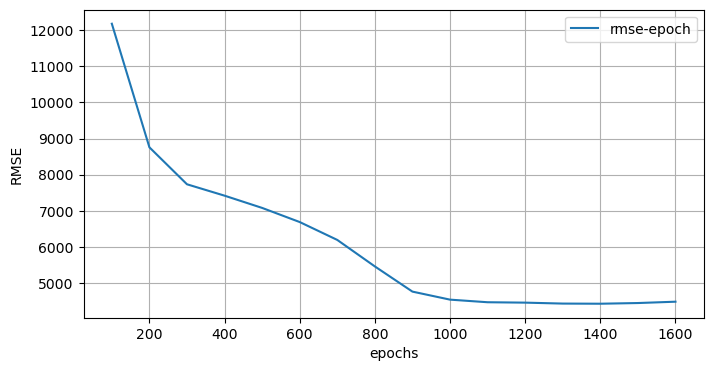

In [78]:
results = [] 
epochs = []

class EarlyStopping():
    def __init__(self, patience=0, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True  
                
early_stopping = EarlyStopping(patience=3, min_delta=10)


net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.LeakyReLU()
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.L1Loss()    

for epoch in range(1, 10001):
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten() 

    loss_value = loss(preds, y_train)
    loss_value.backward()

    optimizer.step()

    if epoch % 100 == 0:  
        net.eval()
        test_preds = net.forward(X_test)
        rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))        
        results = np.append(results, rmse_metric)
        epochs = np.append(epochs, epoch)
        early_stopping(rmse_metric)

        print('EPOCH: ',epoch, '  RMSE: ',rmse_metric)
        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            break 


plt.figure(figsize=[8,4])
sns.lineplot(x=epochs, y=results,  label='rmse-epoch')
plt.legend()
plt.grid(b=True)
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.show()    

Наименьшее значение RMSE наблюдается при 1400 эпох, после чего начинает расти.  С учетом этого для нашей сети количество эпох обучения установим в 1400 эпох.

In [79]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.LeakyReLU()
)

num_epochs = 1400

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.L1Loss()     
   
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten() 
            
    loss_value = loss(preds, y_train)
    loss_value.backward()
            
    optimizer.step()
    
    with torch.no_grad():
        net.eval()
        test_preds = net.forward(X_test)
        
        rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
print('RMSE: ',rmse_metric) 
k = rmse_metric
k

RMSE:  4514


4514

У нейронной сети с двумя скрытыми слоями и обученной за 1400 эпох самая низкая метрика качества RMSE. Эту модель и возьмем в качестве Baseline, которую будем усовершенствовать. 

В соответствии с условием проекта построим график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах. 

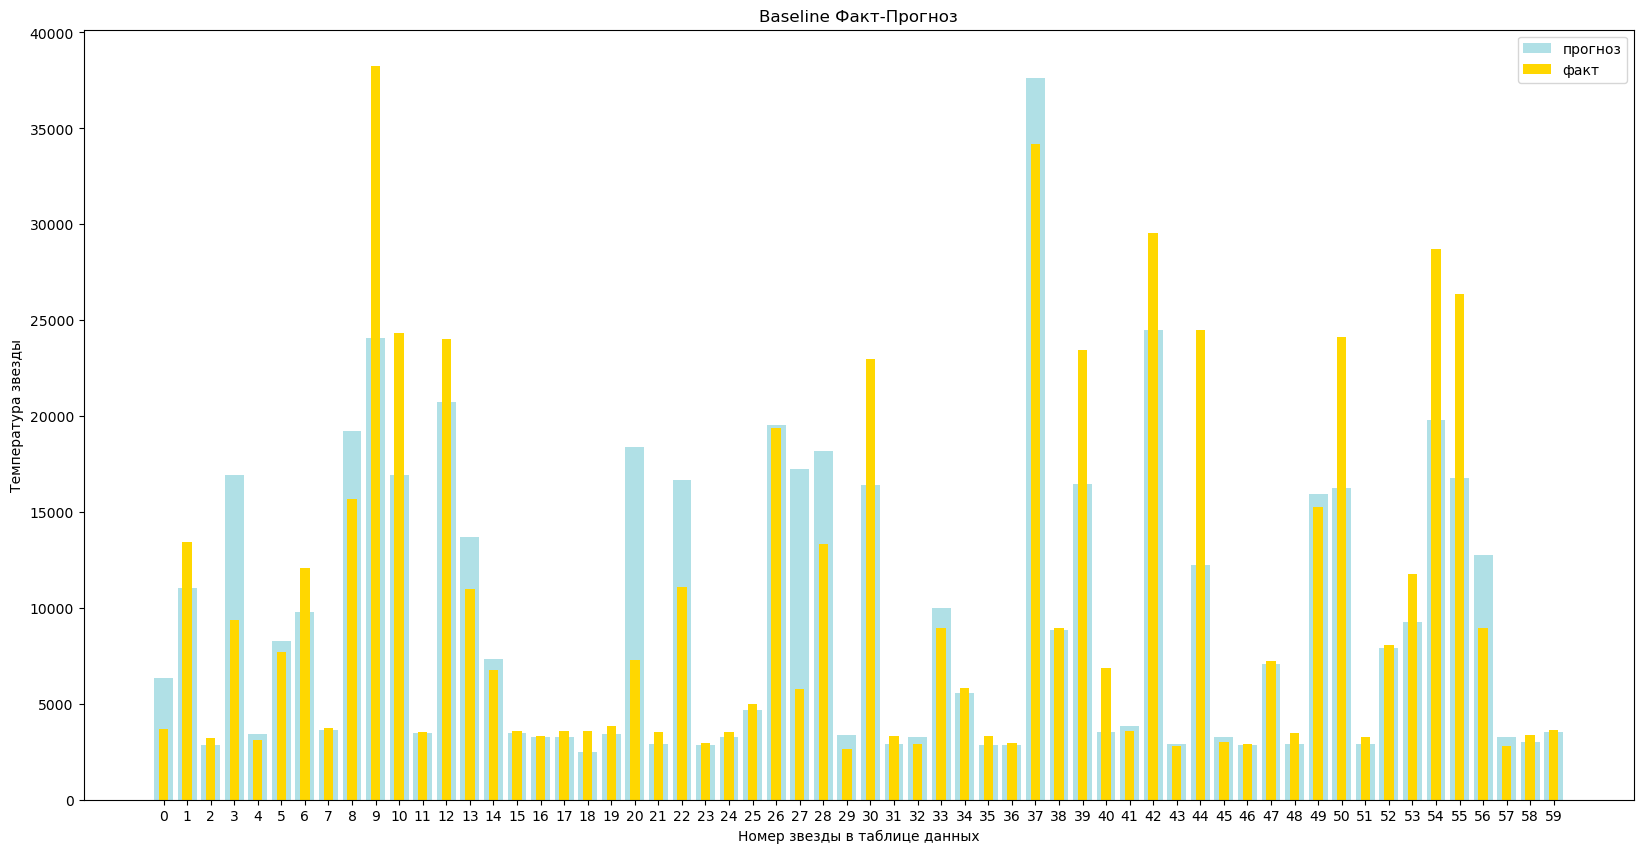

In [80]:
predictions = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])
test = pd.DataFrame(y_test.detach().numpy(), columns=['temperature'])
x = np.arange(len(test))     

fig, ax = plt.subplots(figsize=[20,10])
plt.bar(x=predictions.index, height=predictions['temperature'], color= 'powderblue', label='прогноз')
plt.bar(x=test.index, height=test['temperature'], color='gold', label='факт', width= 0.4)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
ax.set_title('Baseline Факт-Прогноз')
ax.set_xticks(x)
ax.legend()
plt.show()

<b> Вывод:</b> Мы построили три нейронных сети с разными исходными данными - с тремя скрытыми слоями (10, 100, 50, 10, 1 нейрон), одним скрытым слоем (10, 200, 1 нейрон). 
    
Baseline модель обучена при следующих параметрах:полносвязная нейронная сеть с двумя скрытыми слоями и количеством нейронов 10, 500, 800, 1; функция активации ReLU и ее модимикации ELU и LeakyReLU; функция потерь MAE;количество эпох обучения - 1400.

Метрика качества RMSE достигла значение ниже 4514, чуть выше установленного условием проекта 4500.

На графике 'Факт-Прогноз' соотнесены фактическая температура звезд тестовой выборки с предсказанной созданной нами нейронной сетью. Визуально можно отметить, что наиболее точные предсказания получились для звезд с температурой до 5000 градусов. Погрешность в предсказаниях более склоняется в сторону занижения температуры для звезд, фактически имеющих температуру свыше 20000 К и завышения - для звезд с температурой 7000-15000 К.  

## Улучшение нейронной сети

Постараемся усовершенствовать Baseline нейронную сеть путем введения параметра обучения батчами. Для поиска количества батчей, при которых избранная метрика качества покажет наилучшие результаты, переберем их циклом.

In [81]:
batch_values = [64,  48,  32,  16, 8, 5]

batch_size:  64 RMSE:  10215
batch_size:  48 RMSE:  10061
batch_size:  32 RMSE:  9877
batch_size:  16 RMSE:  9299
batch_size:  8 RMSE:  8369
batch_size:  5 RMSE:  7899


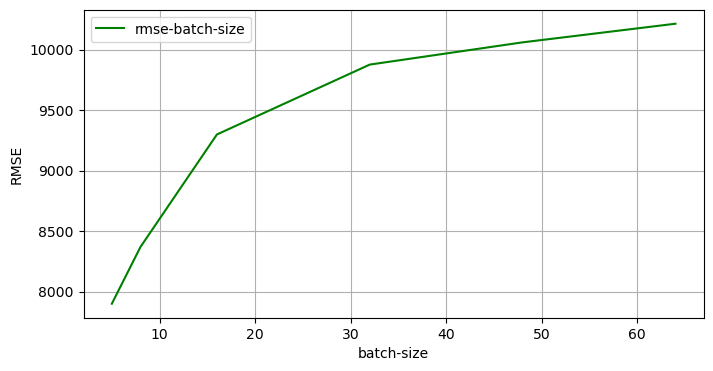

In [82]:
res = [] 
batch = []

for batch_size in batch_values:
        
    net_h2 = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(), 
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ELU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons),
        nn.LeakyReLU())
    
    num_epochs = 1600

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss =  nn.L1Loss() 
            
    num_batches = ceil(len(X_train)/batch_size)
        
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
        
    
        for batch_idx in range(num_batches):

            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net(x_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
                
    net.eval()
    with torch.inference_mode():
        test_preds = net.forward(X_test)
        rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
        
        res = np.append(res, rmse_metric)
        batch = np.append(batch, batch_size)
        
    print('batch_size: ', batch_size, 'RMSE: ', rmse_metric)
    
plt.figure(figsize=[8,4])
sns.lineplot(x=batch, y=res,  color='green', label='rmse-batch-size')
plt.legend()
plt.grid(b=True)
plt.xlabel('batch-size')
plt.ylabel('RMSE')
plt.show()     

Наилучшие результаты достигнуты при  batch_size = 5. Добавим этот параметр в модель.

In [83]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.LeakyReLU()
)

num_epochs = 1400

batch_size = 5

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.L1Loss()     
   
for epoch in range(num_epochs):
        net.train()
        order = np.random.permutation(len(X_train))
        
    
        for batch_idx in range(num_batches):

            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net(x_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
        
            with torch.no_grad():
                net.eval()
                test_preds = net.forward(X_test)
        
                rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
print('RMSE: ',rmse_metric)        
l = rmse_metric
l

RMSE:  7753


7753

Обучение батчами на метрику качества модели положительно не повлияло, метрика повысилась по сравнению с Baseline моделью. Попробуем ее усовершенствовать инициализацией Кайминга.

In [84]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.LeakyReLU()
)
def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

num_epochs = 1400

batch_size = 5

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.L1Loss()     
   
for epoch in range(num_epochs):
        net.train()
        order = np.random.permutation(len(X_train))
        
    
        for batch_idx in range(num_batches):

            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net(x_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
        
            with torch.no_grad():
                net.eval()
                test_preds = net.forward(X_test)
        
                rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
print('RMSE: ',rmse_metric)  
m = rmse_metric
m

RMSE:  7926


7926

Инициализация Кайминга качество модели не повысила. RMSE даже несколько увеличился по сравнению с обучением батчами и не отвечает требованию заказчика (не более 4500). В соответствии с условием проекта применим технику регуляризации Dropout после первого слоя, перебрав этот параметр циклом для поиска такого, при котором метрика качества минимальная.

In [85]:
dropout = np.arange(0.1, 1, 0.1).round(1)
print (dropout)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


dropout_size:  0.1 RMSE:  5022
dropout_size:  0.2 RMSE:  4434
dropout_size:  0.3 RMSE:  4960
dropout_size:  0.4 RMSE:  5298
dropout_size:  0.5 RMSE:  5361
dropout_size:  0.6 RMSE:  5123
dropout_size:  0.7 RMSE:  5276
dropout_size:  0.8 RMSE:  4961
dropout_size:  0.9 RMSE:  5044


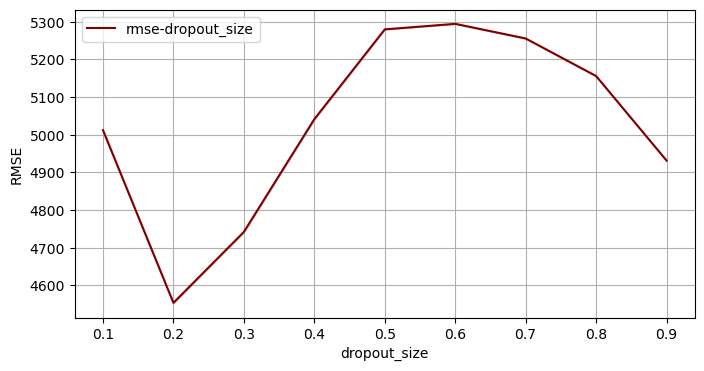

In [86]:
resdp = [] 
drop = []

for dropout_size in dropout:
        
    net_h2 = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Dropout(p=dropout.all()), 
        nn.ReLU(), 
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ELU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons),
        nn.LeakyReLU()) 
    
    def init_weights(layer):
        if type(layer) == nn.Linear: 
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss =  nn.L1Loss()    

    batch_size = 5

    num_epochs = 1400

    num_batches = ceil(len(X_train)/batch_size)


    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
    
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
    
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]  
        
            preds = net.forward(X_batch).flatten()
        
            loss_value = loss(preds, y_batch)
                
            loss_value.backward()
        
            optimizer.step()
            
           
            net.eval()
            test_preds = net.forward(X_test)
            rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
            
            resdp = np.append(resdp, rmse_metric)
            drop = np.append(drop, dropout_size)
            
    print('dropout_size: ', dropout_size, 'RMSE: ',rmse_metric)
    
    

plt.figure(figsize=[8,4])
sns.lineplot(x=drop, y=resdp,  color='maroon', label='rmse-dropout_size')
plt.legend()
plt.grid(b=True)
plt.xlabel('dropout_size')
plt.ylabel('RMSE')
plt.show()      

Самая низкая метрика качества RMSE установлена при добавлении Dropout = 0.2 после первого скрытого слоя. Добавим этот параметр в модель.

In [87]:
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Dropout(p=0.2),
    nn.ReLU(), 
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ELU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.LeakyReLU()
)
def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

num_epochs = 1400

batch_size = 5

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss =  nn.L1Loss()     
   
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten() 
            
    loss_value = loss(preds, y_train)
    loss_value.backward()
            
    optimizer.step()
    
    with torch.no_grad():
        net.eval()
        test_preds = net.forward(X_test)
        
    rmse_metric = round(sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy())))
            
print('RMSE: ',rmse_metric)  
g = rmse_metric
g

RMSE:  4430


4430

Для анализа эффективности методов построения полносвязной нейронной сети построим датафрейм и столбчатую диаграмму.

In [88]:
b = pd.DataFrame({'model': ['dropout', 'kaiming','batches', 'baseline'],
                          'RMSE': [g, m, l, k]})
b

,model,RMSE
0,dropout,4430
1,kaiming,7926
2,batches,7753
3,baseline,4514


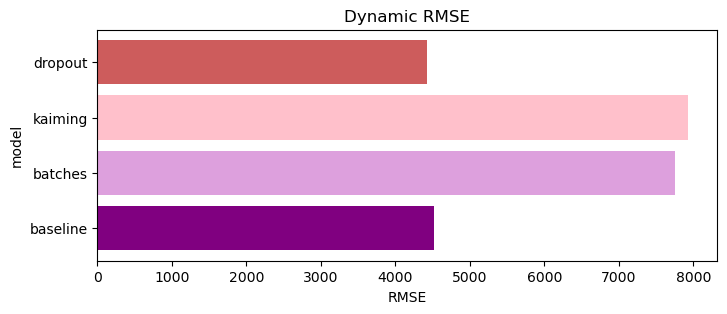

In [89]:
y=['baseline', 'batches', 'kaiming', 'dropout']
x=[k, l, m, g]
fig = plt.figure(figsize = (8, 3))
plt.barh(y, x, color =['purple', 'plum', 'pink', 'indianred'])
plt.ylabel("model")
plt.xlabel("RMSE")
plt.title("Dynamic RMSE")
plt.show()

Теперь еще раз построим график предсказаний

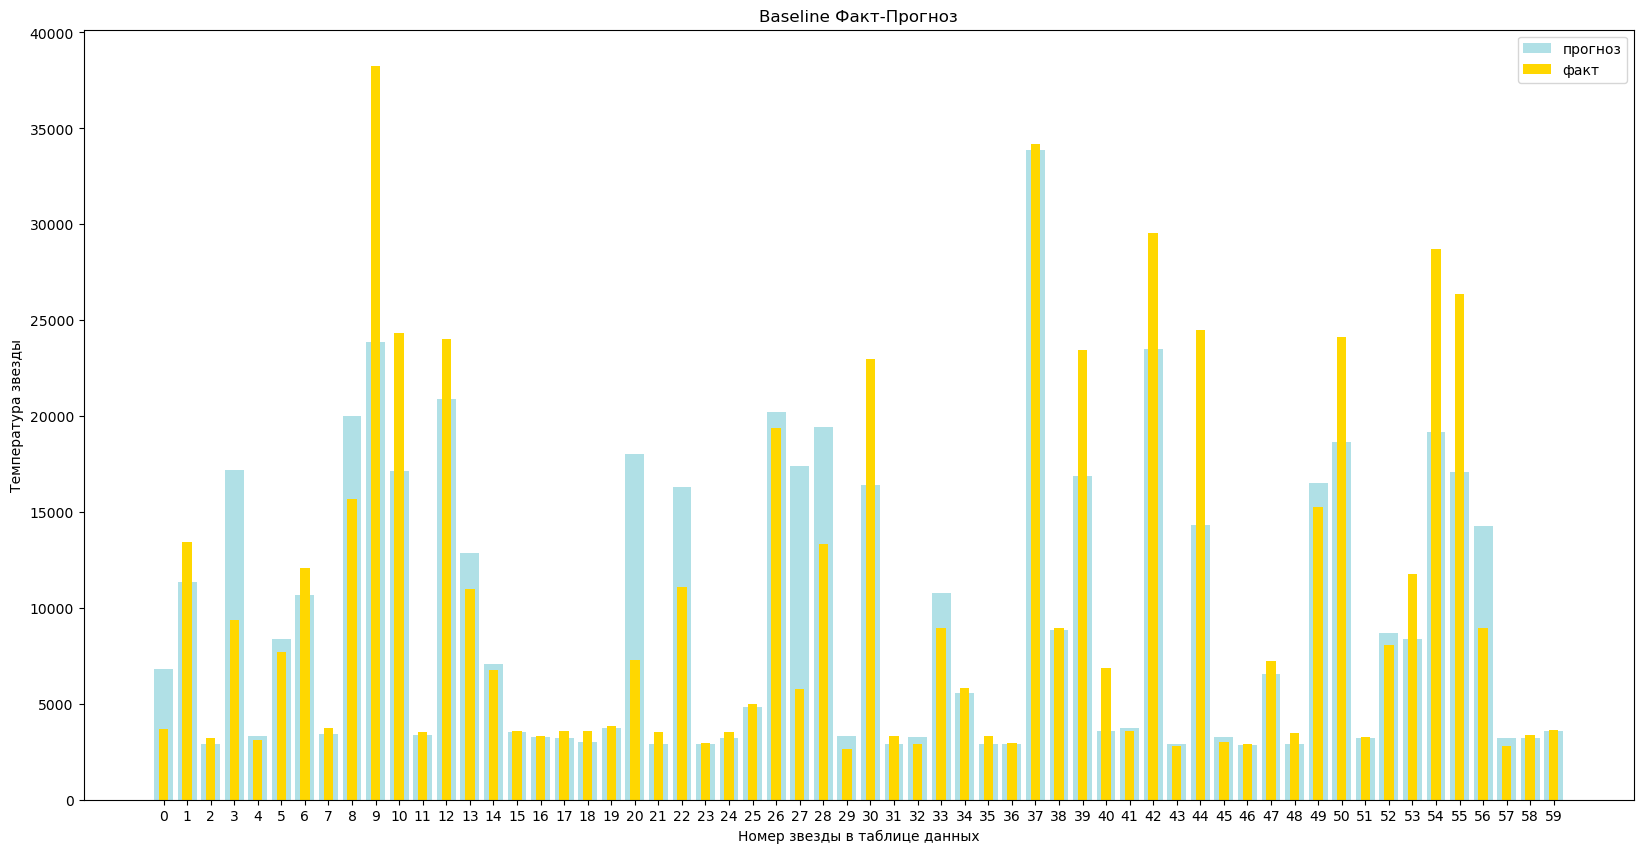

In [90]:
predictions = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])
test = pd.DataFrame(y_test.detach().numpy(), columns=['temperature'])
x = np.arange(len(test))     

fig, ax = plt.subplots(figsize=[20,10])
plt.bar(x=predictions.index, height=predictions['temperature'], color= 'powderblue', label='прогноз')
plt.bar(x=test.index, height=test['temperature'], color='gold', label='факт', width= 0.4)
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
ax.set_title('Baseline Факт-Прогноз')
ax.set_xticks(x)
ax.legend()
plt.show()

<b> Вывод:</b> Для улучшения Baseline модели мы предприняли следующее:
    
ввели параметр обучения батчами, которые перебрали циклом, самая низкая метрика качества RMSE в заданном диапазоне батчей для обучения достигнута при количестве 5 батчей, однако добавление этого параметра модель не улучшило;
    
была применена инициализация Кайминга, которая хоть и повысила качество модели, но не способствовала снижению RMSE до требуемых пределов, 
    
также была применена техника регуляризации Dropout после первого слоя, размер исключаемых нейронов (0.2) подобран путем перебора циклом из установленного диапазона, данная мера способствовала достижению RMSE ниже отметки 4500, что отвечает условию проекта. 
    
RMSE Baseline модели несколько хуже  RMSE модели, построенной после всех улучшений (обучение батчами, инициализация Кайминга, регуляризация Dropout). Однако, на графиках факт-прогноз тенденции одинаковы - максимальная точность предсказаний температуры звезд до 5000 К.  Погрешность в предсказаниях более склоняется в сторону занижения температуры для звезд, фактически имеющих температуру свыше 20000 К и завышения - для звезд с температурой 7000-15000 К.

## Выводы

 <b> Итоговый вывод:</b>  По заказу обсерватории «Небо на ладони» мы построили нейросеть, определяющую температуру на поверхности звезд.
Для построения модели представлены характеристики изученных звёзд. Исходный датасет представлен 240 объектами каждый из которых имеет 5 признаков и целевой признак "Temperature (K)". В двух количественных признаках ('temperature' и 'luminosity') данные распределны нормально, гистограммы признаков 'radius' и 'absolute_magnitude' показывают, что в значениях есть "провалы", что говорит об их неравномерном распределении. Во всех данных, кроме 'star_type', имеются выбросы, от которых мы не стали избавляться ввиду малого количества объектов для построения модели машинного обучения. Предварительная обработка данных состояла в приведении наименований столбцов датасета к общепринятому формату (змеиному регистру), устранению дубликатов в признаке 'star_color', объединении единичных значений этого признака в категорию 'Othes'.

Исследование взаимозависимости признаков выявило между температурой звезды с одной стороны и ее относительной светимостью и относительным радиусом - с другой высокую положительную корреляцию.

Мы разделили данные на учебную и тестовую выборки в соотношении 3:1, после чего обрабатывали данные раздельно по выборкам. К категориальному признаку "star_color" применена техника OHE. Количественные признаки масштабированы.

Для построения модели нейронной сети использована библиотека Torch.

Baseline модель обучена при следующих параметрах:полносвязная нейронная сеть с двумя скрытыми слоями и количеством нейронов 10, 500, 800, 1; функция активации ReLU и ее модимикации ELU и LeakyReLU; функция потерь MAE;количество эпох обучения - 1400. Метрика качества RMSE опустилась до 4514, что немного выше установленного условием проекта 4500.

Для улучшения Baseline модели предпринято следующее.

Введен параметр обучения батчами, размер которых (5 батчей) подобран циклом, однако добавление этого параметра модель не улучшило;

Применена инициализация Кайминга, которая  не способствовала снижению RMSE до требуемых пределов.

Также применена техника регуляризации Dropout после первого слоя, размер исключаемых нейронов (0.2) подобран путем перебора циклом из установленного диапазона, данная мера способствовала достижению RMSE ниже отметки 4500, что отвечает условию проекта.

RMSE Baseline модели несколько хуже RMSE модели, построенной после всех улучшений (обучение батчами, инициализация Кайминга, регуляризация Dropout). Однако, на графиках факт-прогноз тенденции одинаковы - максимальная точность предсказаний температуры звезд до 5000 К. Погрешность в предсказаниях более склоняется в сторону занижения температуры для звезд, фактически имеющих температуру свыше 20000 К и завышения - для звезд с температурой 7000-15000 К. 